In [ ]:
#Installing pycbc
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 5.6 MB/s eta 0:00:00
     

In [ ]:
#Importing libraries
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

from __future__ import division

import numpy 
import lal
import lalsimulation

import matplotlib.pyplot as plt
from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform
import pycbc
from pycbc.filter import resample_to_delta_t, highpass


In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
d = numpy.load("/content/drive/MyDrive/PRA3024_Big_Data_Analysis/Gravitational_Waves/GW_noisedata-2.npy")


In [ ]:
#Downloading the LIGO data from the Hanford (H1) and Livingston (L1) interferometers
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

--2023-03-15 20:01:25--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  46.2MB/s    in 1.2s    

2023-03-15 20:01:27 (46.2 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2023-03-15 20:01:27--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  46.6MB/s    in 1.3s    

20

In [ ]:
# merger = Merger("GW170817") #Loads the data from the GW170817 gravitational wave
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
strain, stilde = {}, {}   #creating empty dictionaries to hold the strain info in the time domain (strain) and the frequency domain (stilde) 
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()

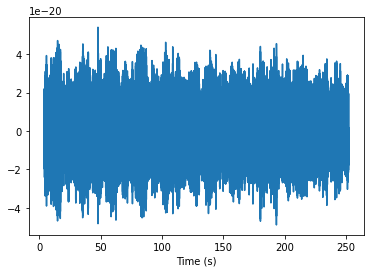

In [ ]:
#Plotting the strain (strain.delta_t) 
pylab.plot(strain['H1'].sample_times, strain['H1']) 
pylab.xlabel('Time (s)') 
pylab.show()

0.004032258064516129

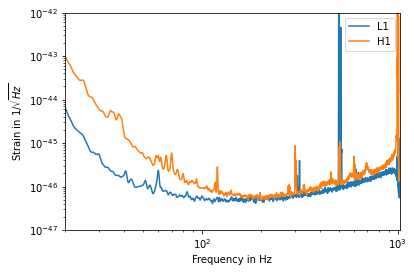

In [ ]:
#Finding the Power Spectral Density of the GW170817 data
import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation


psds = {}
for ifo in ['L1', 'H1']:  

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],  #power spectral density
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)
    #Including inverse spectrum truncation for additional noise removal
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
                                    low_frequency_cutoff=15.0,
                                    trunc_method='hann')
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
    pylab.xlabel("Frequency in Hz")
    pylab.ylabel("Strain in 1/$\sqrt{Hz}$")
pylab.legend()
psds[ifo].delta_f

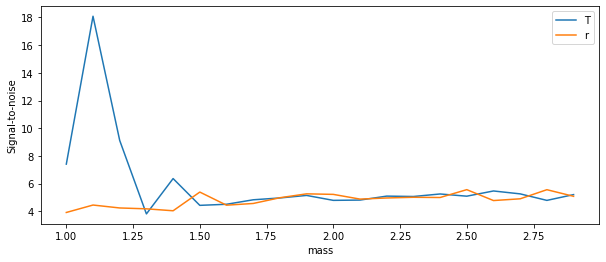

In [ ]:
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy
#Calculating the Matched Filter

#1. Define mass range between 1 and 3 solar masses
mass1 = numpy.arange(1, 3,0.10 )
mass2 = mass1  # Equal masses for sake of simplicity

#2. Variables to store for finding the matched filter with highest SNR
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {} 
ifo_1 = 'H1' 
Snr_list = []

#3. Generating the waveform. For simplicity's sake, assuming no spin
for i in range(len(mass1)): 
    m = mass1[i] 
    hp, hc = get_td_waveform(approximant="TaylorT2",  #hp is plus, hc is cross ; using TaylorT2 approximant
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,  #Setting time steps equal to that of the strain
                     f_lower=15.0)

    # Resizing hp to same length as strain
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time) # template = K(t)
    
    #Calculating signal-to-noise ratio
    snr = matched_filter(template, strain[ifo_1],
                     psd=psds[ifo_1], low_frequency_cutoff=15.0)
    
    #Cropping SNR
    snr_H1 = snr.crop(4 + 4, 4)

    #Taking the max of the absolute value, to get the real part of the SNR
    Snr_list.append(max(abs(snr_H1)))

#Adding the snr list to the SNR dictionary
snrs[ifo_1] = Snr_list
#Repeating the same steps for L1
ifo_2 = 'L1' 
Snr_list = []

for i in range(len(mass1)): 
    m = mass1[i] 
    hp, hc = get_td_waveform(approximant="TaylorT2", 
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo_2].delta_t,  
                     f_lower=15.0)
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time) 
    snr = matched_filter(template, strain[ifo_2],
                     psd=psds[ifo_2], low_frequency_cutoff=15.0)
    snr_L1 = snr.crop(4 + 4, 4)
    Snr_list.append(max(abs(snr_L1)))

#Adding the snr list to the SNR dictionary
snrs[ifo_2] = Snr_list

#Plotting SNR against mass
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

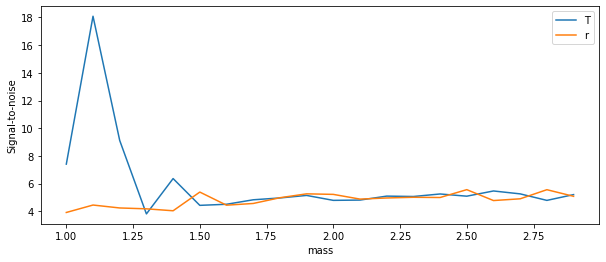

In [ ]:

# Plotting SNR against mass
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

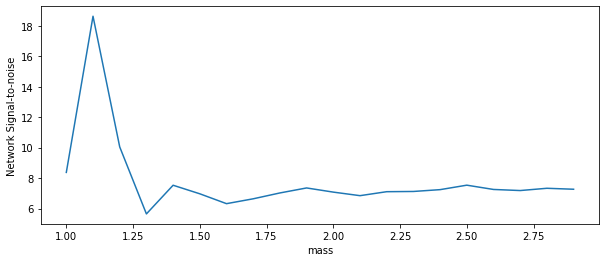

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [ ]:
#Finding best mass value
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5 #Combining the SNR's
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

In [ ]:
print(mass1[ii])

[1.1]


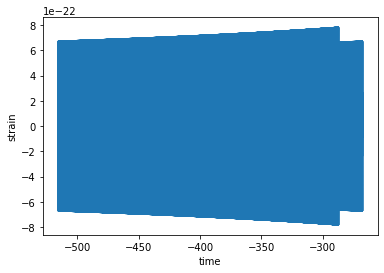

In [ ]:
#Generating waveform with this specific found mass
m = mass1[ii]
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# Resizing hp to same length as strain

hp.resize(len(conditioned))

#Shifting template waveform so that the starting time corresponds to that of the data
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()


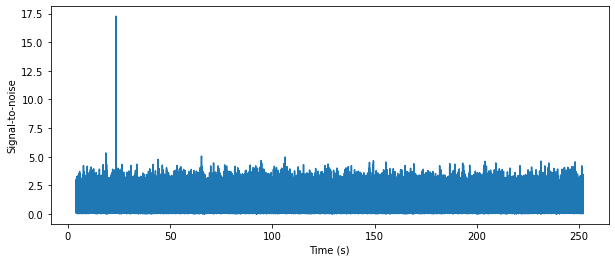

We found a signal at 23.5673828125s with SNR 17.26137155421533


In [ ]:
#Calculating SNR for both H1 and L1 and then combining, using the calculated mass
ifo_1 = 'L1'                            
conditioned1 = strain[ifo_1]
snr_L1 = matched_filter(template, conditioned1,
                     psd=psds[ifo_1] , low_frequency_cutoff=20)
snr_L1.crop(4+4, 4)

#Plotting 
pylab.figure(figsize=[10, 4])
pylab.plot(snr_L1.sample_times, abs(snr_L1))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()


snr_L1_array = numpy.asarray(snr_L1)
peak = abs(snr_L1_array).argmax()
snrp = snr_L1_array[peak]
time = snr_L1.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [ ]:
#We found our signal. Now we will represent it by fitting the template waveform against the data of L1
from pycbc.filter import sigma

# Shift the template so that it starts at same time as data
dt = time - conditioned1.start_time
aligned = template.cyclic_time_shift(dt)

#Scaling the template to have an SNR of 1, for comparison purposes
aligned /= sigma(aligned, psd=psds[ifo_1], low_frequency_cutoff=20.0)

# Scaling the template amplitude and phase to value of the SNR Peak
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned1.start_time

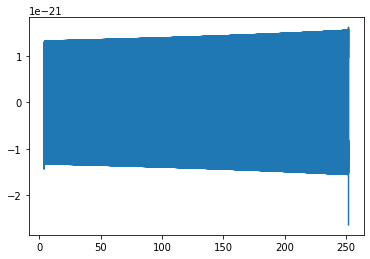

In [ ]:
pylab.plot(aligned.sample_times, aligned, label="Template")


In [22]:
#Whitening the data 
white_data = (conditioned.to_frequencyseries() / psds[ifo_1]**0.5).to_timeseries()

#Highpass filter for the template 
#Whitening and highpass+lowpass filtering of the data

tapered = aligned.highpass_fir(100, 512, remove_corrupted=False)
white_template = (aligned.to_frequencyseries() / psds[ifo_1]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)

max_snr_time = np.argmax(Snr_list)


#Selecting the time around the merger, as this is the part we want to plot
white_data = white_data.time_slice(max_snr_time-.2, max_snr_time+.1)
white_template = white_template.time_slice(max_snr_time-.2, max_snr_time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

#When I apply filters to the template, it is simply a flat line. Removing all filters, I simply get something that looks like a sin wave. 
# I don't know why I don't have a better fitting template, higher order taylor approximations also don't change it.


NameError: ignored

In [ ]:
#Substracting signal from noise for comparison purposes, to see if we found a proper signal
subtracted = conditioned - aligned

# Plotting the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

    #I don't see a difference in the two plots. There is likely an issue with the finding of the template, also as seen by it's odd shape and bad matching with the data.


In [23]:
# Part 3. 
# Generating waveform with m1 = m2 = 10 solar masses
from pycbc.waveform import get_fd_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

hp10, hc10 = get_td_waveform(approximant="TaylorT2",  #hp is plus, hc is cross ; using TaylorT2 approximant
                     mass1=10,
                     mass2=10,
                     delta_t = 1/2048 , 
                     f_lower=15.0)




In [24]:
#Now generating a set of waveforms with masses between 5 and 15
mass = numpy.arange(5, 15, 0.1)

matches = {} #Creating an empty dictionary to store the match values
for i in range(len(mass)): 
    m_ = mass[i] 
    hp, hc = get_td_waveform(approximant="TaylorT2",  #hp is plus, hc is cross ; using TaylorT2 approximant
                     mass1=m_,
                     mass2=m_,
                     delta_t=1/2048,  #Setting time steps equal to that of the strain
                     f_lower=15.0)
    hp.resize(len(hp10))

    #Generating PSD
    delta_f = 1/hp.duration
    flen = len(hp10)//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, 15)


    #Calculating match and adding to dictionary
    m, index = match(hp10, hp, psd = psd, low_frequency_cutoff=15)
    matches[index] = m

Text(0, 0.5, 'Match')

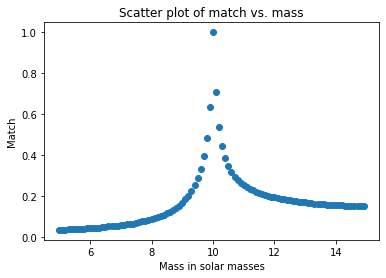

In [25]:
#Plotting the matches against the mass
matches_list = []
for key in matches:
  matches_list.append(matches[key])

plt.plot(mass, matches_list, 'o')
plt.title("Scatter plot of match vs. mass")
plt.xlabel("Mass in solar masses")
plt.ylabel("Match")